# Pyomo -  Linearno programiranje

Ovaj primer ilustruje korišćenje biblioteke Pyomo u radu sa zadacima linearnog programiranja. Rešavač koji ćemo koristiti se zove <a href='https://www.gnu.org/software/glpk/'>GLPK</a> (GNU Linear Programming Kit) i predstavlja zapravo grupu rešavača (uključuje simpleks metod, metod unutrašnje tačke, metod *branch-and-cut* i mnoge druge). GLPK je potrebno instalirati naredbom `conda install -c conda-forge glpk` pre daljeg rada.  

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
from pyomo.environ import *

Zadatak koji ćemo rešavati tiče se optimizovanja proizvodnje jedne fabrike. Naime, fabrika proizvodi dva tipa proizvoda `X` i `Y` koji joj na mesečnom nivou po proizvedenom primerku donose profit od, redom, 40 dolara i 30 dolara. Da bi se proizveo proizvod `X` potreban je jedan sat rada radnika `A` i dva sata rada radnika `B`, a da bi se proizveo proizvod `Y` po jedan sat rada radnika `A` i `B`. Ako radnik `A` mesečno radi 80 sati, a radnik `B` 100 sati i ako je poznato da tržište zahteva najviše 40 primeraka proizvoda `X`, kako organizovati proizvodnju ove fabrike tako da profit bude što je moguće veći? 

Ako sa $x$ obeležimo broj proizvoda tipa $X$, a sa $y$ broj proizvoda tipa $Y$, problem koji treba optimizovati se svodi na maksimizaciju izraza $$40\cdot x+30\cdot y$$ uz ograničenja 
$$x \le 40$$ 
$$2\cdot x+1\cdot y \le 80$$ 
$$1\cdot x+1\cdot y \le 100$$

Prvo ćemo kreirati sam model pozivom funkcije `ConcreteModel`.

In [3]:
model = ConcreteModel()

Zatim ćemo uvesti promenljive modela $x$ i $y$ korišćenjem funkcije `Var` koje redom predstavljaju broj proizvoda tipa $X$ tj. $Y$. Za navođenje domena ovih promenljivih iskoristićemo parametar `domain` i njegovu vrednost predstaviti na `NonNegativeReals` tj. na negativan realan broj. Biblioteka uz ovaj tip podržava i tipove `Reals` i `Binary`. Alternativno, umesto parametra `domain` može se koristiti parametar `within`. 

In [4]:
model.x = Var(domain=NonNegativeReals)

In [5]:
model.y = Var(domain=NonNegativeReals)

Zatim ćemo definisati ciljnu funkciju modela, korišćenjem funkcije `Objective`. Parametrom `sense` naglasićemo da je reč o zadatku maksimizacije. Posebno, parametrom `name` ćemo imenovati i ciljnu funkciju.

In [6]:
model.profit = Objective(expr=40*model.x + 30*model.y, sense=maximize, name='profit')

Ograničenja koja su navedena uslovom zadatka konstruisaćemo funkcijom `Constraint`. Parametrom `expr` ove funkcije se može zadati izraz kojim je određeno ograničenje, a opciono parametrima `name` i `doc` se mogu imenovati i objasniti uvedena ograničenja. Konstruisana ograničenja pridružićemo modelu preko imenovanih svojstava. Mi ćemo koristiti svojstva `demand`, `laborA` i `laborB` koja redom opisuju ograničenja tržišta i uslove rada radnika A i B.

In [7]:
model.demand = Constraint(expr= model.x <= 40)

In [8]:
model.laborA = Constraint(expr= model.x + model.y <= 80)

In [9]:
model.laborB = Constraint(expr= 2*model.x + model.y <= 100)

Informacije o konstruisnom modelu možemo još jednom proveriti pozivom funkcije `pprint` koja ispisuje uvedene promenljive, ogrančenja i formu ciljne funkcije.

In [10]:
model.pprint()

2 Var Declarations
    x : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals
    y : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals

1 Objective Declarations
    profit : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 40*x + 30*y

3 Constraint Declarations
    demand : Size=1, Index=None, Active=True
        Key  : Lower : Body : Upper : Active
        None :  -Inf :    x :  40.0 :   True
    laborA : Size=1, Index=None, Active=True
        Key  : Lower : Body  : Upper : Active
        None :  -Inf : x + y :  80.0 :   True
    laborB : Size=1, Index=None, Active=True
        Key  : Lower : Body    : Upper : Active
        None :  -Inf : 2*x + y : 100.0 :   True

6 Declarations: x y profit demand laborA laborB


Kao što je najavljano, za rešavanje modela iskoristićemo rešavač GLPK. Prvo ćemo ga konstrusati funkcijom `SolverFactory`, a potom ćemo rešiti optimizacioni problem pozivom njegove funkcije `solve`. Rezultat rešavanja sačuvaćemo na nivou povratne vrednosti `result`. 

In [11]:
result = SolverFactory('glpk').solve(model)

Status rešavača nakon rešavanja možemo proveriti svojstvom `status`. Ukoliko je njegova vrednost `ok`, rešavač je uspešno završio pa možemo dalje ispisati rezultate rešavača. Vrednosti traženih promenljivih, kao i vrednost ciljne funkcije možemo pročitati korišćenjem funkcija čija imena odgovaraju imenima svojstava uvedenih na nivou modela.

In [12]:
if result.solver.status == 'ok':
    print('Profit = ', model.profit())
 
    print('\nDecision variables: ')
    print('x = ', model.x())
    print('y = ', model.y())

    print('\nConstraints: ')
    print('Demand  = ', model.demand())
    print('Labor A = ', model.laborA())
    print('Labor B = ', model.laborB())

Profit =  2600.0

Decision variables: 
x =  20.0
y =  60.0

Constraints: 
Demand  =  20.0
Labor A =  80.0
Labor B =  100.0


Propratne informacije vezane za rad rešavača možemo očitati pozivom funkcije `write` na nivou samog rezultata `result`.

In [13]:
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2600.0
  Upper bound: 2600.0
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 3
  Number of nonzeros: 6
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.015925168991088867
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------

Pošto se zbog svoje forme za male dimenzije linearni modeli često i grafički predstavljaju, nadalje sledi prikaz ograničenja kao i površine koja predstavlja prostor dopustivih rešenja.

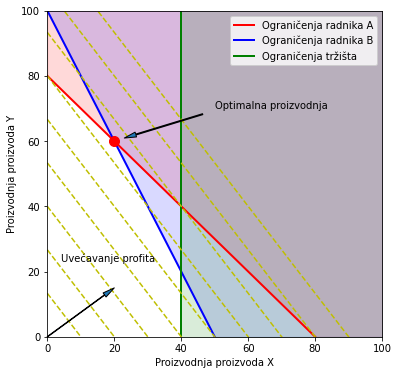

In [14]:
# podešavamo panel za crtanje 
plt.figure(figsize=(6, 6))
plt.axis([0, 100, 0, 100])
plt.xlabel('Proizvodnja proizvoda X')
plt.ylabel('Proizvodnja proizvoda Y')

# predstavljamo ograničenja radnika A
x = np.array([0, 80])
y = 80 - x
plt.plot(x, y, 'r', lw=2)
plt.fill_between([0, 80, 100], [80, 0, 0], [100, 100, 100], color='r', alpha=0.15)

# predstavljamo ograničenja radnika B
x = np.array([0, 50])
y = 100 - 2*x
plt.plot(x, y, 'b', lw=2)
plt.fill_between([0, 50, 100], [100, 0, 0], [100, 100, 100], color='b', alpha=0.15)

# predstavljamo uslove tržišta
plt.plot([40, 40], [0, 100], 'g', lw=2)
plt.fill_between([40, 100], [0, 0], [100, 100], color='g', alpha=0.15)

plt.legend(['Ograničenja radnika A', 'Ograničenja radnika B', 'Ograničenja tržišta'])

# dodajemo šrafuru
x = np.array([0, 100])
for p in np.linspace(0, 3600, 10):
    y = (p - 40*x)/30
    plt.plot(x, y, 'y--')

    
# dodajemo informacije o rešenju
plt.plot(20, 60, 'r.', ms=20)
plt.annotate('Optimalna proizvodnja', xy=(20, 60), xytext=(50, 70), arrowprops=dict(shrink=.1, width=1, headwidth=5))

plt.text(4, 23, 'Uvećavanje profita')
plt.annotate('', xy=(20, 15), xytext=(0, 0), arrowprops=dict(width=0.5, headwidth=5))

# prikazujemo grafik
plt.show()